# The idea

**In this data analysis project, I aim to predict the outcomes of tennis matches by leveraging live match data. Unlike traditional approaches that utilize various game statistics, my innovative approach revolves around strategically reversing the role of bookmakers. I employ real-time odds for individual players as a primary predictor to determine the ultimate winner while the match is in progress. 
While additional parameters contribute to the predictive model, the central element lies in utilizing odds provided by bookmakers. This novel methodology seeks to capitalize on the unique insights offered by betting markets to enhance the accuracy of match outcome predictions.**

# Required imports

In [1]:
# Install libraries
!pip3 install -r requirements.txt

In [2]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf     
from keras.layers import *
from tensorflow import keras
from datetime import datetime
from keras.models import Model
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.colors import LinearSegmentedColormap
from sklearn.base import BaseEstimator, TransformerMixin

# GPU setup
**Optional!**

In [3]:
!nvidia-smi

Tue Dec 12 09:19:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8    14W /  N/A |    217MiB /  7982MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


# Dataset explanation:**


-  **id:** *(int)* A specific match's ID. It is only unique within an exact match time series. A specific row is identidied by the combination of **`id`** and **`actual_time`**.
-  **type:** *(str)* The type of the match. Contains only singles matches, not doubles. Split by gender
-  **city:** *(str)* The name of the city where the match was played
-  **start_time:** (long) DateTime of match start in milliseconds
-  **actual_time:** (long) DateTime when the sample was collected
-  **home_name:** *(str)* Name of the home player
-  **away_name:** *(str)* Name of the guest player
-  **home_rank:** *(int)* The ranking of home player. -1 if not awailable
-  **away_rank:** *(int)* The ranking of guest player. -1 if not awailable
-  **home_odds:** *(float)* Betting odds for home player wins at **`actual_time`** moment
-  **away_odds:** *(float)* Betting odds for guest player wins at **`actual_time`** moment
-  **home_point:** *(int)* Game points that home player had at **`actual_time`** moment. AD converted to 50
-  **away_point:** *(int)* Game points that guest player had at **`actual_time`** moment. AD converted to 50
-  **home_set_1:** *(int)* Games won by home player in set 1. Default is 0
-  **away_set_1:** *(int)* Games won by guest player in set 1. Default is 0
-  **home_set_2:** *(int)* Games won by home player in set 2. Default is 0
-  **away_set_2:** *(int)* Games won by guest player in set 2. Default is 0
-  **home_set_3:** *(int)* Games won by home player in set 3. Default is 0
-  **away_set_3:** *(int)* Games won by guest player in set 3. Default is 0
- **winner** *(int)* Who won the match. 0 = home, 1 = guest

# Datset prerprocessing using pilines

In [7]:
# Previeww
df = pd.read_csv('assets/dataset.csv')
df

,id,type,city,start_time,actual_time,home_name,away_name,home_rank,away_rank,home_odds,away_odds,home_point,away_point,home_set_1,away_set_1,home_set_2,away_set_2,home_set_3,away_set_3,winner
0,3104110,férfi egyes,Santa Margherita di Pula,1695293400000,1695304575254,FED. ARNABOLDI,C. LOPEZ MONTAGUD,581,364,2.85,1.39,40,0,4,6,6,4,4,5,0
1,3086131,férfi egyes,Bad Waltersdorf,1695300900000,1695304577941,A. RAMOS-VINOLAS,P. NOUZA,97,770,1.05,10.50,0,0,6,2,1,0,0,0,0
2,3088678,női egyes,Parma,1695299400000,1695304578488,BONDÁR A.,V. TOMOVA,105,85,1.42,2.75,0,0,7,5,1,4,0,0,0
3,3087124,férfi egyes,Saint-Tropez,1695303600000,1695304584559,R. ALBOT,P. GOJOWCZYK,114,423,1.13,5.50,0,0,2,1,0,0,0,0,0
4,3104110,férfi egyes,Santa Margherita di Pula,1695293400000,1695304584839,FED. ARNABOLDI,C. LOPEZ MONTAGUD,581,364,2.26,1.58,40,0,4,6,6,4,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207185,3118821,női egyes,Lujan,1695905700000,1695911006644,J. ESTABLE,M.M. BOVIO,842,-1,1.00,9.00,15,15,6,1,5,2,0,0,0
207186,3118821,női egyes,Lujan,1695905700000,1695911032168,J. ESTABLE,M.M. BOVIO,842,-1,1.00,9.00,30,15,6,1,5,2,0,0,0
207187,3118821,női egyes,Lujan,1695905700000,1695911053169,J. ESTABLE,M.M. BOVIO,842,-1,1.00,9.00,40,15,6,1,5,2,0,0,0
207188,3118821,női egyes,Lujan,1695905700000,1695911074176,J. ESTABLE,M.M. BOVIO,842,-1,1.00,9.00,40,30,6,1,5,2,0,0,0


## Create pipelines

In [8]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    '''
    From a feature engineering perspective, creating new attributes
    '''

    def fit(self, X, y=None):        
        return self
    
    def transform(self, X):
        # Calculate elapsed time
        X["elapsed_time"] = X["actual_time"] - X["start_time"]

        return X

class Dropper(BaseEstimator, TransformerMixin):
    '''
        A custom scikit-learn transformer for filtering tennis match data based on specific criteria.

        Parameters:
        - time_interval (int): The minimum time interval a match should span to be considered.
        - min_samples (int): The minimum number of samples required for a match to be included.

        Methods:
        - fit(X, y=None): Fit the transformer to the input data (not utilized in this case).
        - transform(X): Apply the filtering criteria to the input data.        
    '''

    def __init__(self, time_interval, min_samples):
        self.time_interval = time_interval
        self.min_samples = min_samples

    def fit(self, X, y=None):        
        return self
    
    def transform(self, X):
        # Remove matches where one player has no rank
        # X = X[(X["home_rank"] != -1) & (X["away_rank"] != -1)]

        # Remove matches where data collecting started too late        
        rows_to_remove = X.groupby('id').filter(lambda x: x['actual_time'].min() < self.time_interval)
        X = X.drop(rows_to_remove.index)

        # Remove matches where data collection ran for too short amount of time
        rows_to_remove = X.groupby('id').filter(lambda x: (x['actual_time'].max() - x['actual_time'].min()) < self.time_interval)
        X = X.drop(rows_to_remove.index)

        # Remove matches which does not have enough samples        
        rows_to_remove = X.groupby('id').filter(lambda x: len(x) < self.min_samples)
        X = X.drop(rows_to_remove.index)

        # Remove matches which has a gap in their timeline        
        X.sort_values(by=['id', 'actual_time'], inplace=True)
        X['elapsed_time'] = X.groupby('id')['actual_time'].diff().fillna(0)
        condition = (X.groupby('id')['elapsed_time'].transform('max') >= self.time_interval)
        rows_to_remove = X[condition].index
        X = X.drop(rows_to_remove)

        # Remove matches where data collection failed
        X = X[X.groupby('id')['home_point'].transform(lambda x: not (x == 0).all())]

        return X

class Sorter(BaseEstimator, TransformerMixin):
    '''
        A custom scikit-learn transformer for sorting tennis match data by timestamp.
    '''

    def fit(self, X, y=None):   
        return self
    
    def transform(self, X):
        # Sort data by timestamp
        X = X.sort_values(by = ['id', 'actual_time'], ascending = True)

        return X

In [9]:
pipe = Pipeline([
    ("features", FeatureCreator()),
    ("dropper", Dropper(
        15 * 60 * 1000, # 15 minutes
        80
    )),
    ("sorter", Sorter())
])

df = pipe.fit_transform(df)

In [10]:
print(f"{df['id'].nunique()} matches in total")
print("Is there any duplicated data:", df.duplicated().value_counts())
print("In average every match contains this many data rows:", df.id.value_counts().mean())
print("Matches max row count:", df.id.value_counts().max())
print("Matches min row count:", df.id.value_counts().min())
df

478 matches in total
Is there any duplicated data: False    161921
Name: count, dtype: int64
In average every match contains this many data rows: 338.7468619246862
Matches max row count: 738
Matches min row count: 82


,id,type,city,start_time,actual_time,home_name,away_name,home_rank,away_rank,home_odds,...,home_point,away_point,home_set_1,away_set_1,home_set_2,away_set_2,home_set_3,away_set_3,winner,elapsed_time
17017,3071940,női egyes,Bukarest,1694590200000,1694590711797,N. AKUGUE NOHA,I.D. AMARIEI,165,396,1.13,...,15,0,0,0,0,0,0,0,0,0.0
17018,3071940,női egyes,Bukarest,1694590200000,1694590734428,N. AKUGUE NOHA,I.D. AMARIEI,165,396,1.13,...,30,0,0,0,0,0,0,0,0,22631.0
17019,3071940,női egyes,Bukarest,1694590200000,1694590739404,N. AKUGUE NOHA,I.D. AMARIEI,165,396,1.19,...,30,0,0,0,0,0,0,0,0,4976.0
17020,3071940,női egyes,Bukarest,1694590200000,1694590756310,N. AKUGUE NOHA,I.D. AMARIEI,165,396,1.19,...,30,0,0,0,0,0,0,0,0,16906.0
17021,3071940,női egyes,Bukarest,1694590200000,1694590774275,N. AKUGUE NOHA,I.D. AMARIEI,165,396,1.19,...,30,15,0,0,0,0,0,0,0,17965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207052,3119085,férfi egyes,Falun,1695902400000,1695909292237,M. DAHLIN,E. KARLOVSKIY,1026,473,14.00,...,0,30,4,6,5,6,0,0,1,4314.0
207055,3119085,férfi egyes,Falun,1695902400000,1695909315755,M. DAHLIN,E. KARLOVSKIY,1026,473,10.50,...,0,30,4,6,5,6,0,0,1,23518.0
207058,3119085,férfi egyes,Falun,1695902400000,1695909323126,M. DAHLIN,E. KARLOVSKIY,1026,473,10.50,...,0,40,4,6,5,6,0,0,1,7371.0
207060,3119085,férfi egyes,Falun,1695902400000,1695909325135,M. DAHLIN,E. KARLOVSKIY,1026,473,13.00,...,0,40,4,6,5,6,0,0,1,2009.0


# Dataset visualization
**Just from the oddson graph, you can see that the odds of the winner are nicely separated throughout the match, rarely crossing each other**

/tmp/ipykernel_6926/2481256201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["actual_time"] = (sample["actual_time"] - sample["start_time"])  / 1000 / 60


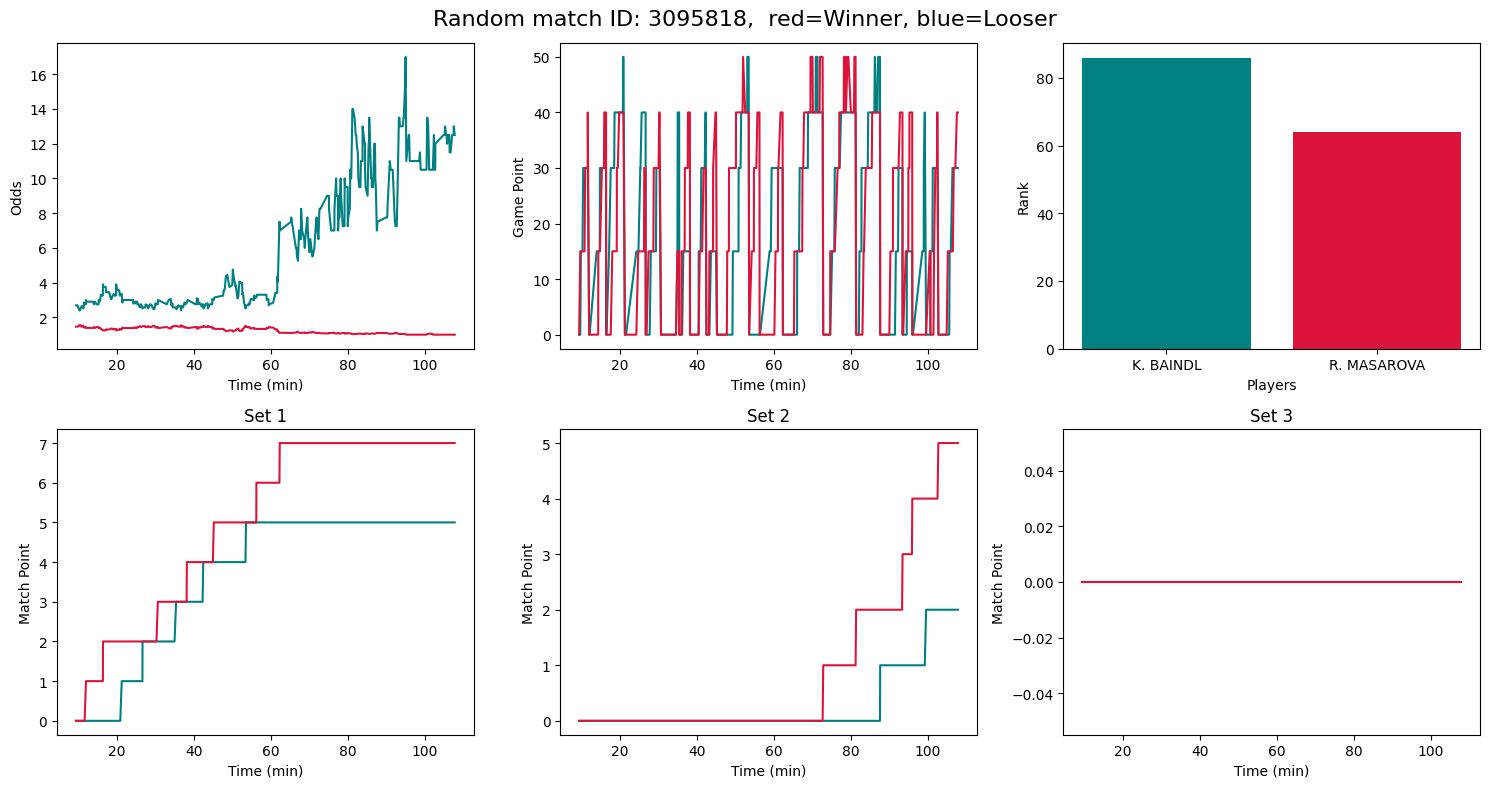

In [18]:
# Single match visualization

# Select a random sample
sample = df[df["id"] == int(df.sample(n=1)["id"].iloc[0])]
sample["actual_time"] = (sample["actual_time"] - sample["start_time"])  / 1000 / 60
winner = int(sample["winner"].iloc[0])
home_rank = int(sample["home_rank"].iloc[0])
away_rank = int(sample["away_rank"].iloc[0])
home_name = sample["home_name"].iloc[-1]
away_name = sample["away_name"].iloc[-1]

# Determine winner color
if winner == 0:
    home_color = "crimson"
    away_color = "teal"
elif winner == 1:
    home_color = "teal"
    away_color = "crimson"
else:
    home_color = "green"
    away_color = "purple"

# Create subplot with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# First subplot
axs[0, 0].plot(sample['actual_time'], sample['home_odds'], color=home_color)
axs[0, 0].plot(sample['actual_time'], sample['away_odds'], color=away_color)
axs[0, 0].set_xlabel('Time (min)')
axs[0, 0].set_ylabel('Odds')

# Second subplot
axs[0, 1].plot(sample['actual_time'], sample['home_point'], color=home_color)
axs[0, 1].plot(sample['actual_time'], sample['away_point'], color=away_color)
axs[0, 1].set_xlabel('Time (min)')
axs[0, 1].set_ylabel('Game Point')

# Third subplot
axs[0, 2].bar([home_name, away_name], [home_rank, away_rank], color=[home_color, away_color])
axs[0, 2].set_xlabel('Players')
axs[0, 2].set_ylabel('Rank')

# Fourth subplot
axs[1, 0].plot(sample['actual_time'], sample['home_set_1'], color=home_color)
axs[1, 0].plot(sample['actual_time'], sample['away_set_1'], color=away_color)
axs[1, 0].set_title("Set 1")
axs[1, 0].set_xlabel('Time (min)')
axs[1, 0].set_ylabel('Match Point')

# Fifth subplot
axs[1, 1].plot(sample['actual_time'], sample['home_set_2'], color=home_color)
axs[1, 1].plot(sample['actual_time'], sample['away_set_2'], color=away_color)
axs[1, 1].set_title("Set 2")
axs[1, 1].set_xlabel('Time (min)')
axs[1, 1].set_ylabel('Match Point')

# Sixth subplot
axs[1, 2].plot(sample['actual_time'], sample['home_set_3'], color=home_color)
axs[1, 2].plot(sample['actual_time'], sample['away_set_3'], color=away_color)
axs[1, 2].set_title("Set 3")
axs[1, 2].set_xlabel('Time (min)')
axs[1, 2].set_ylabel('Match Point')


# Set title
plt.suptitle(f'Random match ID: {int(sample["id"].iloc[0])},  red=Winner, blue=Looser', fontsize=16)

# Az ábrák megjelenítése
plt.tight_layout()  # Az ábrák közötti térköz beállítása
plt.show()

# Analyze dataset

**The correlation matrix clearly shows the relationships between the attributes. Here we want to know which values have the strongest influence on the *winner* attribute**.

**These show that what is important for us is the ODDS, and the results of the first set.  From this we can conclude that it is ideal to wait at least for the results of the first set before making a final prediction**

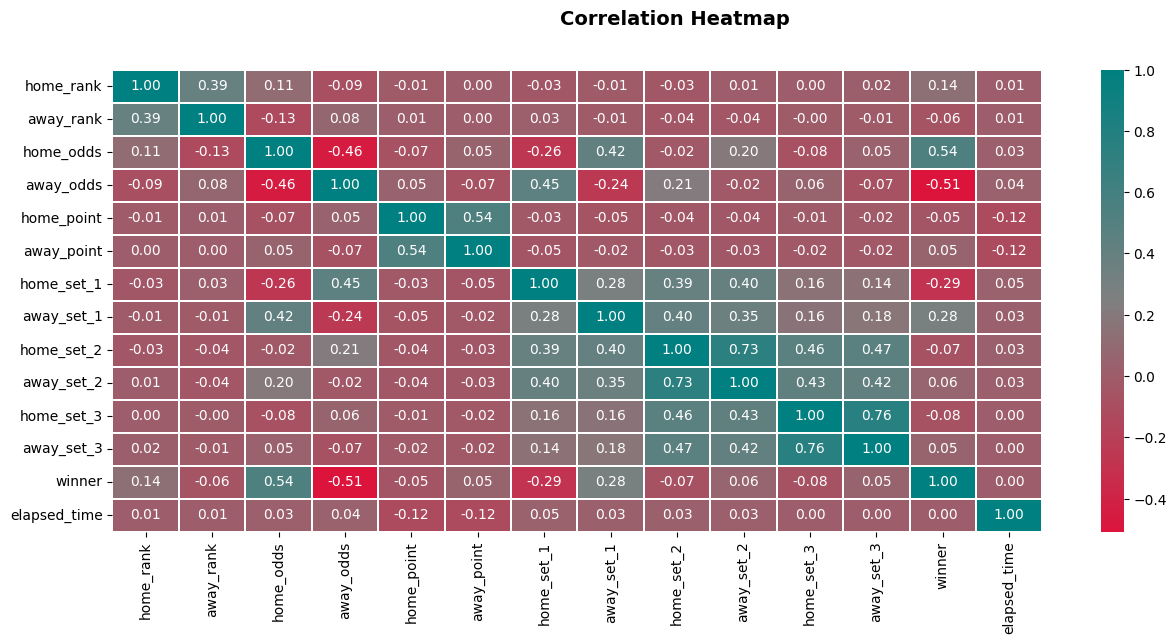

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
hm = sns.heatmap(df.iloc[:, 7:].corr(),
                ax=ax,
                cmap=LinearSegmentedColormap.from_list('', ["crimson", (0.5, 0.5, 0.5), "teal"], N=256),
                annot=True,
                fmt='.2f',
                linewidths=0.05)
fig.suptitle('Correlation Heatmap',
                fontsize=14,
                fontweight='bold')

plt.show()

/tmp/ipykernel_6926/1038420490.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["winner"] == 1]["home_odds"], bins=100, label="Looser Odds", color="teal")
/tmp/ipykernel_6926/1038420490.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["winner"] == 0]["home_odds"], bins=100, l

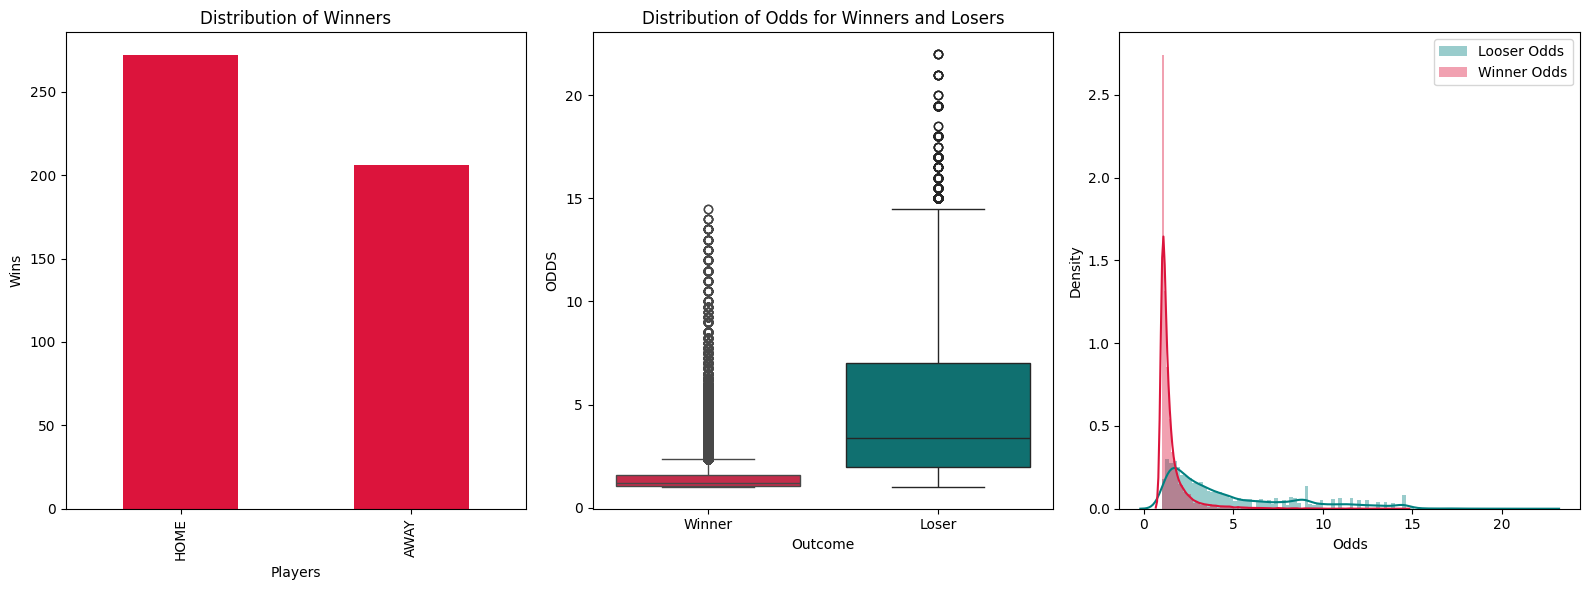

In [20]:


# Először hozzunk létre egy üres ábra keretet
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# Az első ábra: Distribution of Winners
unique_winners = df.drop_duplicates(subset=["id"])["winner"].value_counts()
unique_winners.plot(kind="bar", color="crimson", ax=ax1)
ax1.set_xticks(range(2))
ax1.set_xticklabels(['HOME', 'AWAY'])
ax1.set_xlabel("Players")
ax1.set_ylabel("Wins")
ax1.set_title("Distribution of Winners")

# A második ábra: Distribution of Odds for Winners and Losers
sns.boxplot(x="winner", y=df[df["winner"] == 0]["home_odds"], data=df, color="crimson", ax=ax2)
sns.boxplot(x="winner", y=df[df["winner"] == 1]["home_odds"], data=df, color="teal", ax=ax2)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(["Winner", "Loser"])
ax2.set_ylabel("ODDS")
ax2.set_xlabel("Outcome")
ax2.set_title("Distribution of Odds for Winners and Losers")


sns.distplot(df[df["winner"] == 1]["home_odds"], bins=100, label="Looser Odds", color="teal")
sns.distplot(df[df["winner"] == 0]["home_odds"], bins=100, label="Winner Odds", color="crimson")
ax3.set_xlabel("Odds")
ax3.legend()


plt.tight_layout()
plt.show()

# Conclusion  

**The data set is relatively balanced. Unsurprisingly, the distribution of odds shows that the winning player has a smaller**
**It is likely that this will affect the prediction model so that the higher the confidence value for a prediction, the lower the odds will be.**

In [21]:
# The following attributes are used to teach the model
FEATURES = ["winner", "id", "home_odds", "away_odds", "home_point", "away_point", "home_set_1", "away_set_1", "home_set_2", "away_set_2", "home_set_3", "away_set_3"]
df = df[FEATURES]

# Normalization

In [22]:
class Normalizer(BaseEstimator, TransformerMixin):

    def __init__(self, scaler):
        self.scaler = scaler

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        to_normalize_labels = X.iloc[:, 2:].columns        
        X[to_normalize_labels] = self.scaler.fit_transform(X[to_normalize_labels])

        return X

In [83]:
# sca = MinMaxScaler()

# normalizer = Normalizer(sca)
# df = normalizer.fit_transform(df)

/tmp/ipykernel_26475/1122486301.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[to_normalize_labels] = self.scaler.fit_transform(X[to_normalize_labels])


# Prepate data for model
**Each match is treated as a different time series, which results in different lengths. The values of each time series must be added up to the maximum length to obtain a uniform size**

**The target variable is separated and the data set is plit**

In [23]:
length = df.id.value_counts().max()
X = list()
y = list()
for id, data in df.groupby('id'):
    match = data.columns

    placeholder = np.full((length - len(match), match.shape[1]), -1)
    match = np.append(match, placeholder, axis=0)
    
    X.append(match)
    y.append(data["winner"].values[0])
X = np.array(X)
y = np.array(y)

permutation = np.random.permutation(len(X))
X = X[permutation]
y = y[permutation]
    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

IndexError: tuple index out of range

# The model
**For time series, an LSTM model is perfectly suited, which in turn is used for time series prediction, so it has been extended with output layers to be used for binary classification**

In [24]:
ip = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Permute((2, 1))(ip) # dimension shuffle
x=LSTM(2)(x)
x = Dropout(0.6)(x)


y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(ip)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = GlobalAveragePooling1D()(y)

x = concatenate([x, y])
out = Dense(2, activation='softmax')(y)
model = Model(ip, out)

model._name = f"TennisModel_{datetime.now().strftime('%Y-%m-%d-%H%M')}_{len(X_train)}"

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()

NameError: name 'X_train' is not defined

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5",
    monitor = 'val_loss',
    verbose = 2,
    save_best_only = True,
    save_freq = 'epoch',
    mode = "min"
)


history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test,y_test), 
    epochs=100, 
    batch_size=16, 
    verbose=2,
    callbacks=[checkpoint] # , early_stopping
)

Epoch 1/100


2023-10-25 12:04:10.305029: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8904
2023-10-25 12:04:11.320451: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: val_loss improved from inf to 1.18749, saving model to model.h5
25/25 - 5s - loss: 0.3884 - accuracy: 0.8497 - val_loss: 1.1875 - val_accuracy: 0.8557 - 5s/epoch - 184ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.18749 to 0.36123, saving model to model.h5
25/25 - 0s - loss: 0.2165 - accuracy: 0.9404 - val_loss: 0.3612 - val_accuracy: 0.9278 - 306ms/epoch - 12ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.36123 to 0.33085, saving model to model.h5
25/25 - 0s - loss: 0.1935 - accuracy: 0.9404 - val_loss: 0.3308 - val_accuracy: 0.9485 - 295ms/epoch - 12ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.33085 to 0.26038, saving model to model.h5
25/25 - 0s - loss: 0.1686 - accuracy: 0.9482 - val_loss: 0.2604 - val_accuracy: 0.9691 - 288ms/epoch - 12ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.26038
25/25 - 0s - loss: 0.1478 - accuracy: 0.9611 - val_loss: 0.2733 - val_accuracy: 0.9794 - 261ms/epoch - 10ms/step
Epoch 6/100

Epoch 6: val_loss di

In [25]:
# Load best
model = keras.models.load_model("model.h5")

2023-12-12 09:43:25.124058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-12 09:43:25.195087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-12 09:43:25.195512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-12 09:43:25.196726: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [19]:
loss, acc = model.evaluate(X_test, y_test)
model._name = model._name+f"_{loss}_{acc}"

4/4 [==============================] - 0s 6ms/step - loss: 0.1313 - accuracy: 0.9794


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


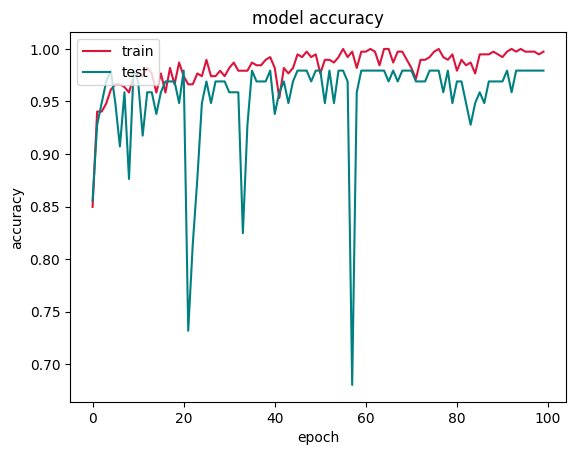

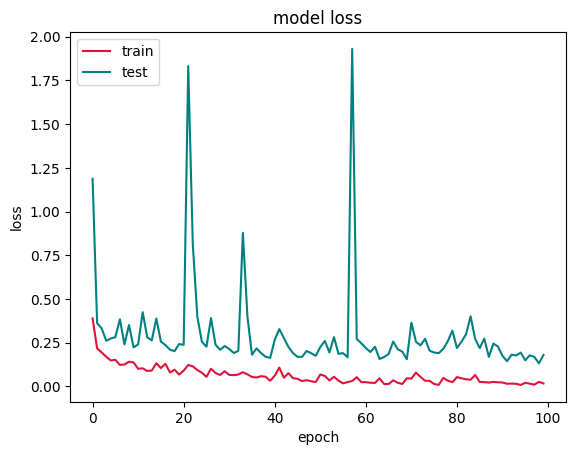

In [20]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'], color="crimson")
plt.plot(history.history['val_accuracy'], color="teal")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], color="crimson")
plt.plot(history.history['val_loss'], color="teal")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

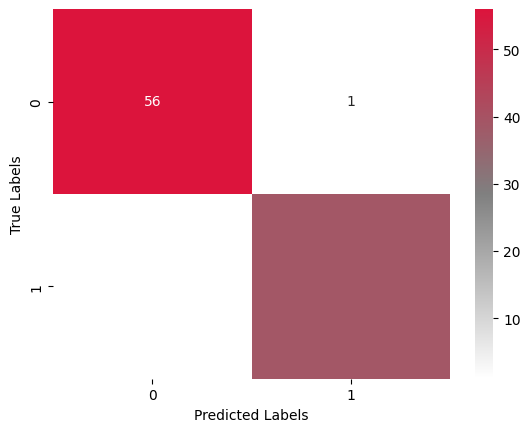

In [21]:
# Create the confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1).tolist()
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
sns.heatmap(confusion_matrix, annot=True, cmap=LinearSegmentedColormap.from_list('', ["white", (0.5, 0.5, 0.5), "crimson"], N=256))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


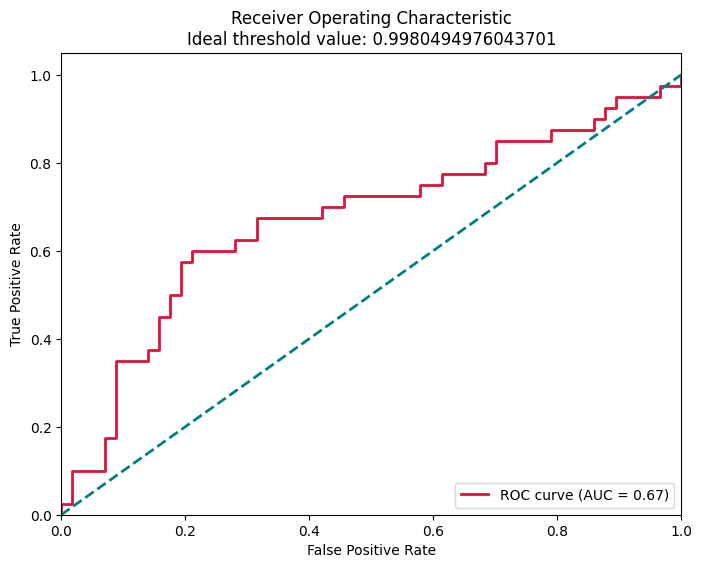

In [22]:
y_pred_prob = np.amax(model.predict(X_test), axis=1)


roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

ideal_threshold = thresholds[np.argmax(tpr - fpr)]
model._name = model._name+f"_{ideal_threshold}"


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="crimson", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="teal", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Receiver Operating Characteristic\nIdeal threshold value: {ideal_threshold}")
plt.legend(loc="lower right")
plt.show()


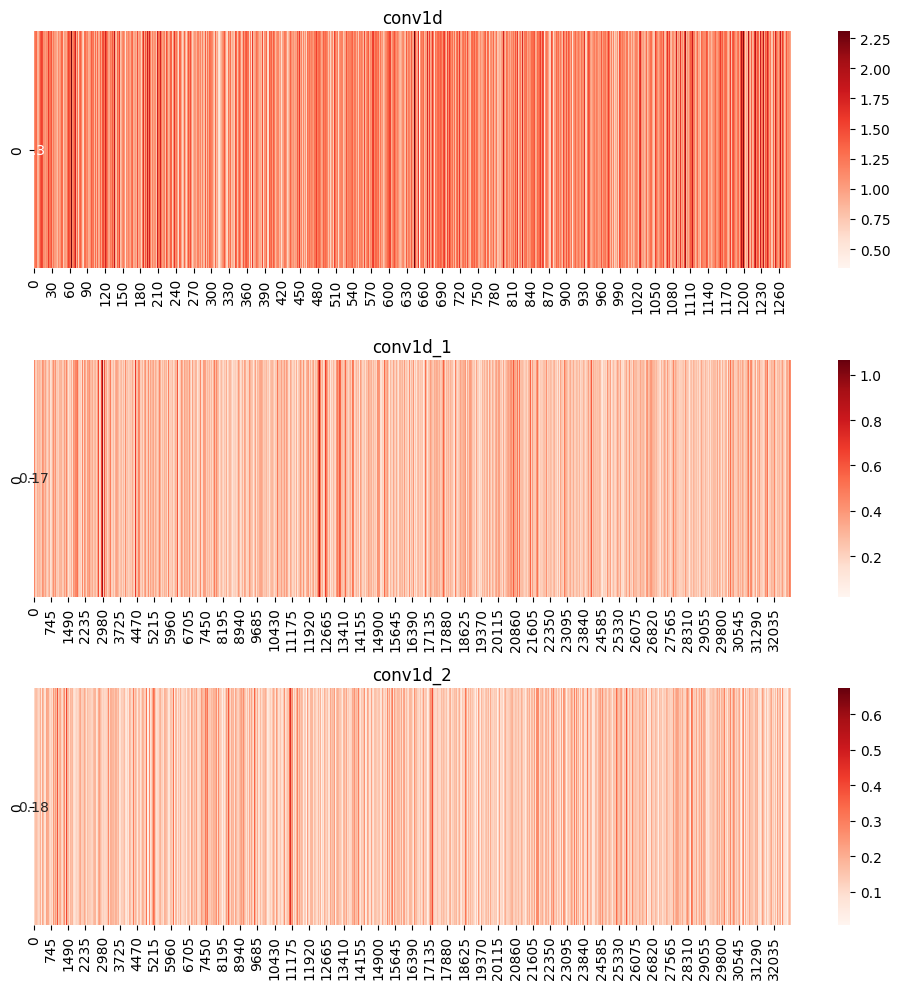

In [23]:
conv_layers = []
for layer in model.layers:
    if "conv" in layer.name:
        conv_layers.append(layer)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=len(conv_layers), figsize=(10, 10))

for i, layer in enumerate(conv_layers):
    if "conv" in layer.name:
        weights = layer.get_weights()[0]
        importances = np.sum(np.abs(weights), axis=0)

        axs[i].set_title(layer.name) # itt adjuk hozzá a címet

        sns.heatmap(importances.reshape(1, -1), annot=True, cmap='Reds', ax=axs[i])

fig.tight_layout()
plt.show()

In [24]:
model.save('model.h5') 

# Deploy
**The following class can be used for continuous prediction of a live match. The current values at the time are passed to it, and then it gives us a prediction using the current threshold values**

In [25]:
class Predictor:

    def __init__(self, model_path):
        self.model =  keras.models.load_model(model_path)
        self.data_length = self.model.input_shape[1]
        self.name = self.model._name.split('_')[0]
        self.version = self.model._name.split('_')[1]
        self.train_data = self.model._name.split('_')[2]
        self.loss = self.model._name.split('_')[3]
        self.accuracy = self.model._name.split('_')[4]
        self.threshold = self.model._name.split('_')[5]

        print(f"{self.name} model loaded. Version: {self.version}, Train data: {self.train_data}, Loss: {self.loss}, Accuracy: {self.accuracy}, Threshold: {self.threshold}")

    def predict(self, data):
        data = self.expand_data(data)
        
        pred = self.model.predict(data)[0]

        result = np.argmax(pred)
        confidence = pred[result]

        return result, confidence
    
    def expand_data(self, data):
        if len(data) > self.data_length:
            data = data[:-self.data_length]
        else:
            placeholder = np.full((self.data_length - len(data), data.shape[1]), -1)
            data = np.append(data, placeholder, axis=0)

        return np.expand_dims(data,axis=0)


p = Predictor("model.h5")
cl, co = p.predict(X_test[1][:120])
print(f"Predicted class: {cl} with {co} confidence")

TennisModel model loaded. Version: 2023-10-25-1204, Train data: 386, Loss: 0.131333589553833, Accuracy: 0.9793814420700073, Threshold: 0.9980494976043701
Predicted class: 1 with 0.7164271473884583 confidence


# Live testing & results

**Testing in a live environment showed that the model can successfully predict the winner during the match. Unfortunately, however, it is not suitable for sports betting purposes, because when the level of confidence in some decisions reaches an acceptable level, even the bookmakers give very low odds on the outcome. The model tracks changes in odds too closely.**

![WEB INTERAFCE](./assets/img.png "Title")